# Motivations et notitions de bases



## Quelque aspect technique avant de commencer

Il est très important d'exécuter la section ci-dessous, même si, d'un point de vue pratique, elle ne fait que préparer les instruments dont nous allons nous servir plus tard dans le document.

In [4]:
# libraries

# installation, à faire une seule fois
# install.packages("ggplot2") 
# install.packages ("scale")

# chargement
library(ggplot2) 
library(scales) # chargement

# couleur pour le graphique
darkred  = "#8B0000"   


## Création d'un jeu de données simulé

Pour introduire les notions de base qui nous accompagneront pour le reste du cours, nous allons simuler un jeu de données qui nous permettra de modifier facilement les caractéristiques de l'étude exemple et d'en observer les effets.

Dans cette étude exemple, nous allons simuler un jeu de données dans lequel nous mesurons les niveaux d'anxiété état sur le questionnaire STAI-S et les niveaux socio-économiques de 120 participant-e-x-s. Le niveau socio-économique va de 1 à 20, avec 1 étant le niveau le plus bas et 20 le niveau le plus élevé. Le niveau d'anxiété état varie entre 20 et 80, avec des scores au-delà de 50 indiquant une souffrance importante.

Dans le jeu de données que nous allons simuler, nous allons aussi insérer une relation entre les scores d'anxiété et le niveau socio-économique.


In [17]:
set.seed(1223) # cela c'est pour la reproductibiilité

# Nombre de participants
n <- 120

# générer un statut socio-économique entre 1 et 20
socioecon <- rep(0:19, length.out = n)


# Simuler les scores d'anxiété avec une distribution gamma ajustée
base_anxiety <- round(qgamma(ppoints(n), shape = 10, scale = 100))  # Ajustement pour réduire les 20
base_anxiety <- scales::rescale(base_anxiety, to = c(20, 80))


# Générer des scores d’anxiété influencés par le statut socio-économique
anxiety_scores <- round(base_anxiety - socioecon * 2 + rnorm(n, 0, 5))
anxiety_scores <- anxiety_scores+25

anxiety_scores <- pmax(pmin(anxiety_scores, 80), 20)


# Création du dataset final
simulated_data <- data.frame(
  sub_id = 1:n,                   # identifiant des participants
  socioecon = socioecon,          # Statut socio-économique
  anxiety = anxiety_scores        # Score d'anxiété
)

# Vérification des premières lignes
head(simulated_data)



,sub_id,socioecon,anxiety
,<int>,<int>,<dbl>
1,1,0,47
2,2,1,43
3,3,2,40
4,4,3,39
5,5,4,47
6,6,5,45


## La distribution 

Un concept très important est celui de la distribution des données. La distribution des données décrit comment les valeurs d'une variable sont réparties. Elle peut être représentée graphiquement par des histogrammes ou des courbes de densité. Cela sera un concept central pour tous les chapitres de cours sur les méthodes bayésiennes, mais il est aussi au cœur des statistiques fréquentistes.

Une manière très intuitive et pratique de s'approcher du concept de distribution est la représentation graphique en histogramme.

Nous savons que l'échelle d'anxiété varie entre 20 et 80. Ce que nous allons faire dans la construction de l'histogramme, c'est de compter le nombre de participants qui ont répondu entre certains intervalles de valeurs, par exemple entre 20-25, 25-30, 35-40, ... 75-80. Ensuite, dans l'histogramme, nous traçons des barres pour chaque intervalle, la hauteur des barres indiquant combien de participants ont rapporté une valeur dans cet intervalle dans notre échantillon. Cela nous permet d'identifier quelles sont les valeurs qui apparaissent le plus souvent dans l'échantillon et quelles sont les valeurs plus rares.

L'unité de regroupement ici est de 5, mais nous pouvons la modifier selon nos besoins. Dans le code ci-dessous, vous pouvez modifier cette valeur et voir comment cela impacte la représentation de la distribution des données.

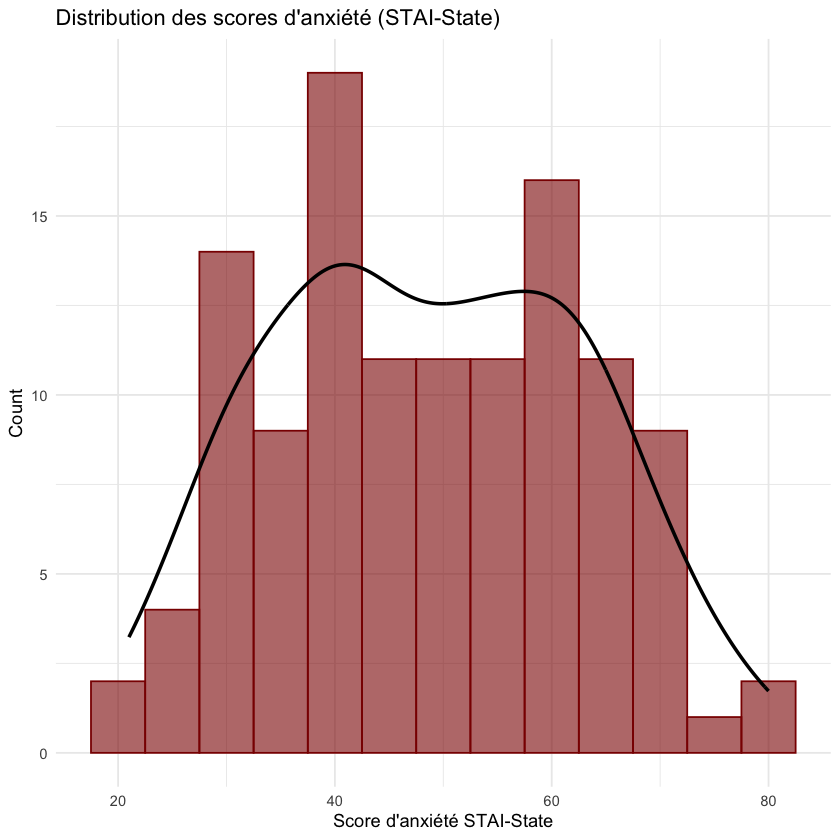

In [19]:
bin_size = 5

ggplot(simulated_data, aes(x = anxiety)) +
  geom_histogram(binwidth = bin_size, fill = darkred, color = darkred, alpha = 0.6) +
  geom_density(aes(y = ..count.. * bin_size),  color = "black",  linewidth = 1) +  # Ajustement de l'échelle
  labs(title = "Distribution des scores d'anxiété (STAI-State)",
       x = "Score d'anxiété STAI-State",
       y = "Count") +
  theme_minimal()


## L'estimation des paramètres dans un modèle

Un autre concept très important est celui de paramètre (souvent noté comme $\theta$). Ce concept nous accompagnera également pour la suite des chapitres de ce cours. Un paramètre dans un modèle statistique est une valeur numérique qui caractérise une relation entre les variables dans une population. Souvent, la formulation de nos hypothèses de recherche se formalise spécifiquement dans un de ces paramètres. Pour cela, vous verrez plus tard dans le cours très souvent la notation $P(D | \theta)$ qui se réfère à la vraisemblance, c'est-à-dire la probabilité d'observer certaines données étant donné notre hypothèse. Le processus d'estimation des paramètres est au cœur des statistiques fréquentistes et bayésiennes, même s'il se fait par des techniques différentes. Basé sur un modèle $M$ avec des paramètres $\theta$, l'estimation des paramètres aborde la question de savoir quelles valeurs de $\theta$ sont de bonnes estimations, étant donné certaines données $D$.

Il existe beaucoup de modèles différents, mais en principe, vous êtes déjà très familier avec le concept des paramètres dans le modèle linéaire général (GLM). Pour illustrer concrètement cela, nous pouvons prendre notre exemple dans lequel nous souhaitons prédire le score d'anxiété (variable dépendante $y$) en fonction du statut socio-économique (variable indépendante $x$) et appliquer un GLM qui consiste en une simple régression linéaire.

Le modèle de régression linéaire s'écrit comme suit :

$$\hat{y} = \beta_0 + \beta_1 x + \epsilon, \epsilon \sim Normal(0, \sigma)$$

ou:

* $\hat{y}$ : variable prédite par le modèle, e.g., le score d'anxiété prédit par le modèle
* $y$ : variable dépendante, e.g., c'est le score d'anxiété mesuré
* $x$ : variable indépendante, e.g., le statut socio-économique qui varie entre 1 et 20
* $\beta_0$ : intercept (ordonnée à l'origine), c'est le paramètre qui représente la valeur moyenne de $\hat{y}$ lorsque $x=0$.
* $\beta_1$ : coefficient de régression, c'est le paramètre qui représente le changement moyen de $\hat{y}$ pour une unité de changement de $x$.
* $\epsilon$ : terme d'erreur (résidus) qui représente la variation de $y$ non expliquée par $x$. Le modèle assume que les résidus suivent une distribution normale au tours de 0 avec certaine variance ($\sigma$). Le symbole $\sim$ signifie "sont distribué selon")

Donc dans le cas d'une régression linaire il y a trois paramètres qui doivent être estimées: $\beta_0$, $\beta_1$ et $\sigma$.

Dans le langage de programmation R, nous pouvons utiliser la fonction `lm` qui implémente un régression linaire pour des études entre les sujets. Cette fonction va estimer les paramètres du modèle de régression en trouvant les paramètres qui meilleur décrivent les données (sous la contrainte du modèle de régression linéaire).

Cela peut être fait comme il suit:



In [22]:
glm_anxiety = lm(anxiety ~socioecon, data = simulated_data)


Nous pouvons accéder au coefficients $\beta_0$ (intercept) et $\beta_1$ comme suit

In [25]:
glm_anxiety


Call:
lm(formula = anxiety ~ socioecon, data = simulated_data)

Coefficients:
(Intercept)    socioecon  
     62.619       -1.482  


et nous pouvons acceder aux coefficent $\sigma$ (variance des résidus) comme il suit:

In [27]:
summary(glm_anxiety)$sigma

[1] 11.31538

Le coefficient $\beta_0$ (`Intercept`) représente la valeur prédite du score d'anxiété lorsque le statut socio-économique (socioecon) est égal à 0. Cela signifie que, dans le statut socio-économique le plus bas de notre échelle, le niveau d'anxiété prédit par notre modèle est d'environ 62.

Le coefficient $\beta_1$ (`socioecon`) représente la pente et indique de combien le score d’anxiété change pour chaque augmentation d'une unité du statut socio-économique. Dans notre cas, les augmentations de statut socio-économique prédisent une diminution du score d'anxiété d'environ 1.5.

Le coefficient $\sigma$ rreprésente la variance du terme d'erreur dans l'unité de l'échelle du score d'anxiété.

Nous pouvons aussi représenter le modèle de regression avec un graphique comme suit:

`geom_smooth()` using formula = 'y ~ x'


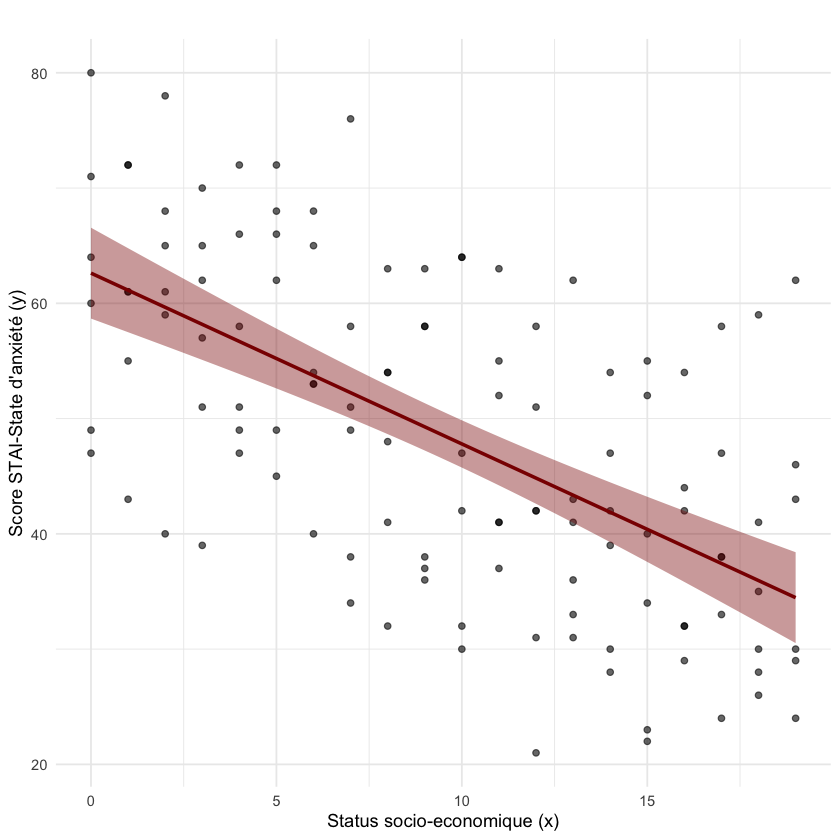

In [29]:
ggplot(simulated_data, aes(x = socioecon, y = anxiety)) +
  geom_point(color = "black", alpha = 0.6) +  # Points des participants
  geom_smooth(method = "lm", color = darkred, se = TRUE, fill = darkred) +  # Régression
  labs(title = "",
       x = "Status socio-economique (x)",
       y = "Score STAI-State d'anxiété (y)") +
  theme_minimal()


Dans la partie de visualisation du modèle, nous pouvons aussi visualiser la distribution des résidus et effectuer une inspection visuelle des postulats.

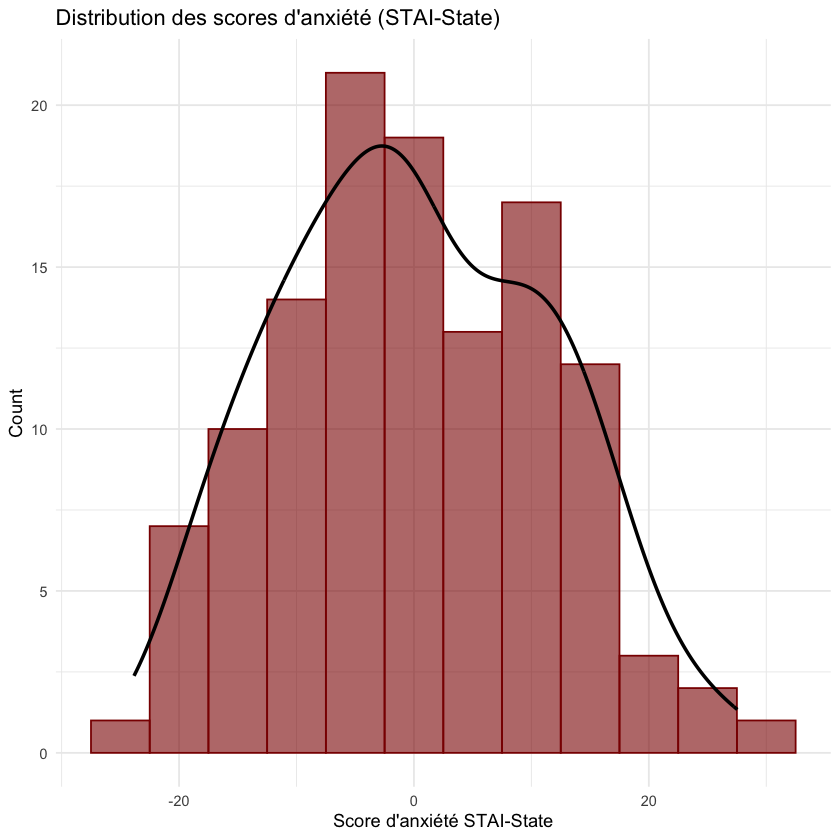

In [33]:
residuals = summary(glm_anxiety)$residuals

bin_size = 5

ggplot(simulated_data, aes(x = residuals )) +
  geom_histogram(binwidth = bin_size, fill = darkred, color = darkred, alpha = 0.6) +
  geom_density(aes(y = ..count.. * bin_size),  color = "black",  linewidth = 1) +  # Ajustement de l'échelle
  labs(title = "Vérifications des postulats",
       x = "Residus du modèle",
       y = "Count") +
  theme_minimal()



La méthode d'estimation des paramètresimplémentée par la fonction`lm` est celle des *Moindres Carrés Ordinaires* souvent abréviée comme OLS (*Ordinary Least Square*)
Cette méthode est relativement simple et consiste a minimiser a somme des carrés des écarts entre les valeurs observées $y$ et les valeurs prédites par le modèle $\hat{y}$.
Comme ça nous interesse pas le sense de la distance on calcule la différence au carré $(y -\hat{y})^2$. On fait ce calcule pour tout les mésures observée (i.e., tout les points dans le modèle de régression) et on calcue la sommation comme suit:

$$SS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

Le modèle avec les paramètres les meilleures est celui qui permet de miminser le resultat de cette sommation.

La méthode OLS utilisée ici pour estimer les paramètres ne peut pas être considérée directement comme une méthode de calcul de la vraisemblance, car elle ne repose pas explicitement sur un cadre probabiliste. Dans la suite du cours, nous verrons comment utiliser des concepts probabilistes tels que la vraisemblance pour estimer les paramètres et comment nous pouvons utiliser des méthodes probabilistes pour améliorer ces estimations en injectant des connaissances que nous avons a priori dans le processus d'estimation